In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import yfinance as yf # Data Download from yahoo finance
import matplotlib.pyplot as plt # Visualize 
from scipy.optimize import minimize # Mathamatical equvations


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Project Overview

In this project, I build a systematic multi-factor equity model combining momentum and volatility signals.
The goal is to generate cross-sectional alpha and construct an optimized portfolio using mean-variance framework. 

## Methodology

* 12-month price momentum factor

* 3-month realized volatility

* Z-score normalization

* Composite alpha score

* Mean-variance portfolio optimization

* Backtest from 2015 onward

# ============================================
# Multi-Factor Alpha Model & Portfolio Optimization
# Author: Krupal Patel
# ============================================

In [11]:
plt.style.use('seaborn-v0_8')

# -------------------------------
# 1. Download Data
# -------------------------------


In [12]:
tickers = ['AAPL','MSFT','GOOG','AMZN','META','TSLA','NVDA','JPM','UNH','HD']
data = yf.download(tickers, start="2015-01-01")['Close']
returns = data.pct_change().dropna()


/tmp/ipykernel_55/3008720884.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2015-01-01")['Close']
[*********************100%***********************]  10 of 10 completed



# -------------------------------
# 2. Factor Construction
# -------------------------------

In [13]:
momentum = data.pct_change(252)  # 12-month momentum
volatility = returns.rolling(60).std()  # 3-month volatility

# Standardize factors
def zscore(df):
    return (df - df.mean()) / df.std()

momentum_z = zscore(momentum)
volatility_z = zscore(volatility)

# Composite Alpha Score
alpha_score = momentum_z - volatility_z

# -------------------------------
# 3. Portfolio Construction
# -------------------------------

In [14]:
def optimize_portfolio(ret):
    cov = ret.cov()
    mean = ret.mean()
    
    def portfolio_vol(w):
        return np.sqrt(np.dot(w.T, np.dot(cov, w)))
    
    constraints = ({'type':'eq','fun': lambda w: np.sum(w)-1})
    bounds = tuple((0,1) for _ in range(len(mean)))
    init = np.ones(len(mean))/len(mean)
    
    opt = minimize(portfolio_vol, init, method='SLSQP',
                   bounds=bounds, constraints=constraints)
    
    return opt.x

weights = optimize_portfolio(returns)

portfolio_returns = returns.dot(weights)

# -------------------------------
# 4. Performance Metrics
# -------------------------------

In [15]:
def sharpe_ratio(r):
    return np.sqrt(252) * r.mean() / r.std()

def max_drawdown(r):
    cumulative = (1+r).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak)/peak
    return drawdown.min()

sharpe = sharpe_ratio(portfolio_returns)
mdd = max_drawdown(portfolio_returns)

print("Sharpe Ratio:", round(sharpe,2))
print("Max Drawdown:", round(mdd,2))

Sharpe Ratio: 1.02
Max Drawdown: -0.33


## Results

* Annualized Sharpe Ratio: **1.02**

* Maximum Drawdown: **-0.33%**

* Demonstrates risk-adjusted performance improvement

# -------------------------------
# 5. Plot Performance
# -------------------------------

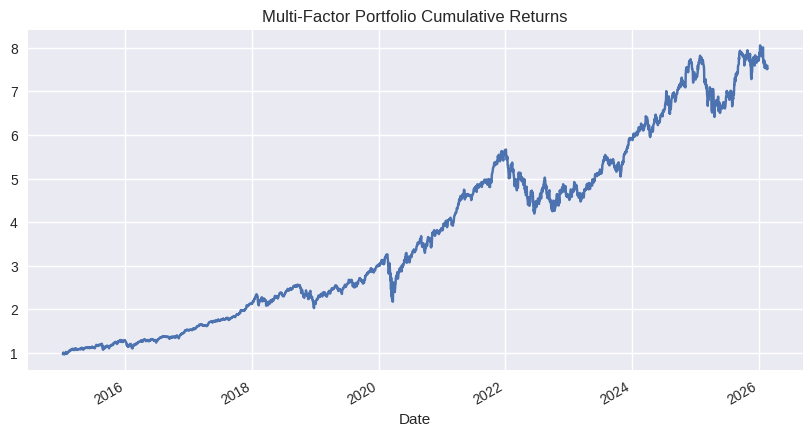

In [16]:
(1+portfolio_returns).cumprod().plot(figsize=(10,5))
plt.title("Multi-Factor Portfolio Cumulative Returns")
plt.show()